In [71]:
# General stuff
import os
import re
import time
import warnings
import math
import sys
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from subprocess import Popen, PIPE
from os.path import join as opj
from IPython.core.debugger import Tracer
from nilearn.decomposition import CanICA,DictLearning
from sklearn.decomposition import DictionaryLearning

# sklearn stuff
from sklearn.utils.extmath import randomized_svd

# personal functions
from importlib import reload
import fsutils as fs
reload(fs)

if os.path.exists('/data1/vbeliveau/'):
    # On NRU server
    cluster_code='/data1/vbeliveau/5HT_clustering'
    cluster_data='/data1/vbeliveau/5HT_clustering_data'
    subjects_dir='/usr/local/nru/freesurfer/subjects'
elif os.path.exists('C:/Users/vbeliveau/'):
    # On laptop
    cluster_code='C:/Users/vbeliveau/Documents/GitHub/5HT_clustering'
    cluster_data='C:/Users/vbeliveau/Documents/5HT_clustering_data'
    subjects_dir='C:/Users/vbeliveau/Downloads/'
else:
    raise ValueError('Unknown location')
    
# Load local version of nilearn
if os.path.exists('/data1/vbeliveau/'):
    sys.path.append('/data1/vbeliveau/nilearn')
    import mynilearn.decomposition as dcm 
    reload(dcm)
elif os.path.exists('C:/Users/vbeliveau/'):
    sys.path.append('C:/Users/vbeliveau/Downloads/nilearn-master')
    import mynilearn.decomposition as dcm
    reload(dcm)
else:
    raise ValueError('Unknown location')
    
# Analysis directories
surf_data=opj(cluster_data,'surf_data')
fs.assert_dir(surf_data)
BPnd_data=opj(cluster_data,'BPnd')
fs.assert_dir(BPnd_data)
MFA_data=opj(cluster_data,'MFA')
MFA_preproc=opj(MFA_data,'preproc')
fs.assert_dir(MFA_data)
fs.assert_dir(MFA_preproc)

info_path=opj(cluster_code,'info_alltracers_base_healthy_hrrt.mat')
info=sio.loadmat(info_path)

In [3]:
# Load data

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh','rh']
targ='fsaverage5'
sm='10'

data=np.empty(len(tracers),dtype=object)
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    for hemi in hemi_type:
        fmask=opj(surf_data,'mask',targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        if data[nt] is None:
            data[nt]=fs.load_surf_data(fname,mask=fmask)
        else:
            data[nt]=np.vstack((data[nt],fs.load_surf_data(fname,mask=fmask)))

In [52]:
# Save out PCA of the data

tracers=['cumi','dasb','sb','az','C36']
hemi_type=['lh','rh']
targ='fsaverage5'
sm='10'

dest=opj(BPnd_data,'pca')
fs.assert_dir(dest)


for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    data=None
    for hemi in hemi_type:
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        fmask=opj(surf_data,'mask',targ+'.'+hemi)
        if data is None:
            data=fs.load_surf_data(fname,mask=fmask)
        else:
            data=np.vstack((data,fs.load_surf_data(fname,mask=fmask)))
            
    U,_,_=randomized_svd(data,10)
    fname=[opj(dest,tracer+'.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
       for hemi in hemi_type]
    fmask=[opj(surf_data,'mask',targ+'.'+hemi) for hemi in hemi_type]
    fs.save_surf_data(U,fname,mask=fmask)

Processing cumi


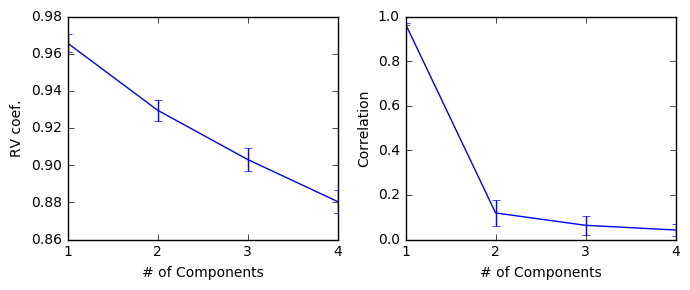

Processing dasb


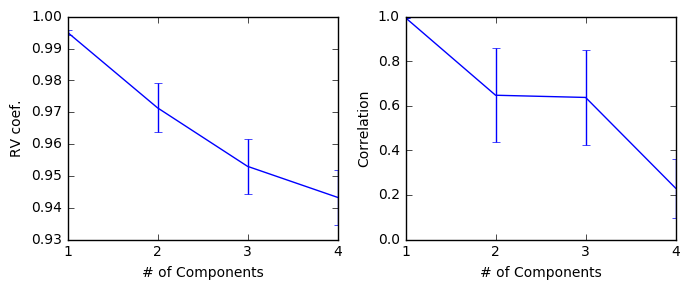

Processing sb


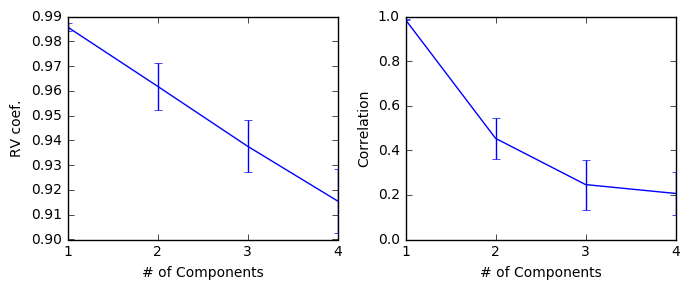

Processing az


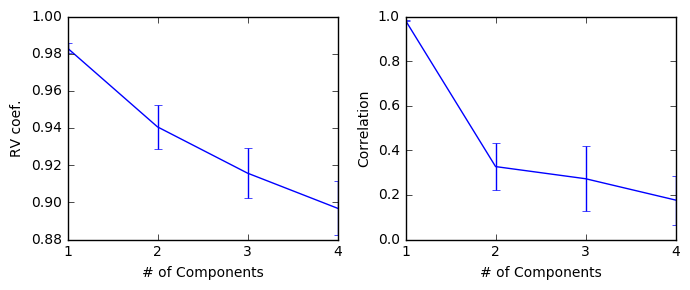

Processing C36


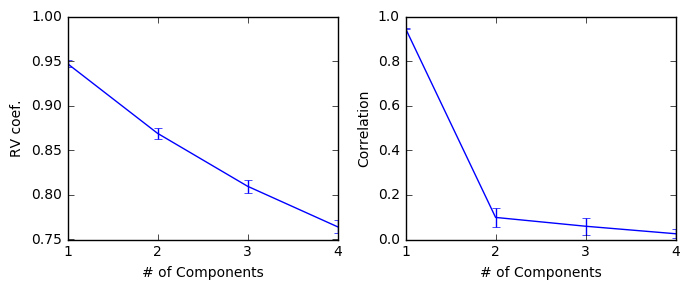

In [25]:
# Evaluate stability and reproducibility of BPnd PCA

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi_type=['lh','rh']
K_max=4
N_iter=100

for tracer,nt in zip(tracers,np.arange(0,len(tracers))+1):
    
    print('Processing '+tracer)
    
    tmp_data=np.empty(len(hemi_type),dtype=object)
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask',targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        tmp_data[nh]=fs.load_surf_data(fname,mask=fmask)
    tmp_data=np.vstack(tmp_data)
    data=np.ndarray(tmp_data.shape[1],dtype=object)
    for nc in np.arange(0,tmp_data.shape[1]):
        data[nc]=tmp_data[:,nc]

    stabil=np.ndarray(K_max,dtype=object)
    for nk in np.arange(0,K_max):
        def func(data):
            U,S,_=randomized_svd(np.column_stack(data),nk+1)
            return (U.T * S[:, np.newaxis]).T

        stabil[nk],_=fs.split_half(data,func,n_iter=N_iter,
                                   repro_metric=None,
                                   stabil_metric='rv')
        
    def func(data):
        U,S,_=randomized_svd(np.column_stack(data),K_max)
        return (U.T * S[:, np.newaxis]).T

    _,repro=fs.split_half(data,func,n_iter=N_iter,
                               repro_metric='corr',
                               stabil_metric=None)
    
    x_range=np.arange(0,K_max)+1
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.errorbar(x_range,
                 [stabil_k.mean() for stabil_k in stabil],
                 yerr=[stabil_k.std() for stabil_k in stabil])
    plt.xticks(x_range)
    
    plt.xlabel('# of Components')
    plt.ylabel('RV coef.')

    plt.subplot(1,2,2)
    plt.errorbar(x_range,
                 repro.mean(axis=0),
                 yerr=repro.std(axis=0))
    plt.xticks(x_range)
    plt.axis([x_range[0],x_range[-1],0,1])
    plt.xlabel('# of Components')
    plt.ylabel('Correlation')

    plt.tight_layout()
    plt.show()

In [67]:
# Perform dictionary learning on individual tracers BPnd for a range of components

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi_type=['lh']
K_max=20

for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    
    print('Processing '+tracer)
    
    dest=opj(BPnd_data,'DictLearning',tracer)
    fs.assert_dir(dest)
    
    hemi_data=np.empty(len(hemi_type),dtype=object)
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask',targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        hemi_data[nh]=fs.load_surf_data(fname,mask=fmask)
    data=np.vstack(hemi_data)
    data=data.astype('float64')
            
    K_range=np.arange(2,min(K_max,data.shape[1])+1)
    for K in K_range:
        components=fs.dict_learning_adapted(data,K,alpha=1)
        fname=[opj(dest,'K'+str(K)+'.'+targ +'.' +hemi+'.sm' + sm + '.nii.gz') 
           for hemi in hemi_type]
        fmask=[opj(surf_data,'mask',targ+'.'+hemi) for hemi in hemi_type]
        fs.save_surf_data(components,fname,mask=fmask)

Processing cumi


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Processing dasb
Processing sb
Processing az
Processing C36


Loading data
Processing K=2


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Processing K=3
Processing K=4


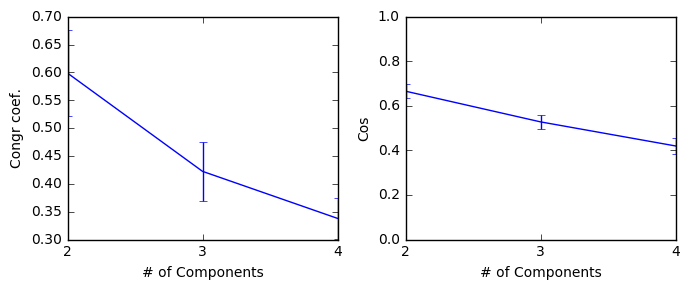

Processing K=2


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Processing K=3
Processing K=4
Processing K=5
Processing K=6
Processing K=7
Processing K=8
Processing K=9
Processing K=10
Processing K=11
Processing K=12
Processing K=13
Processing K=14
Processing K=15
Processing K=16
Processing K=17
Processing K=18
Processing K=19
Processing K=20


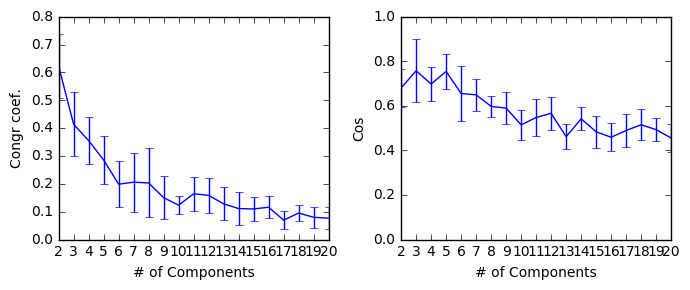

Processing K=2


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Processing K=3
Processing K=4
Processing K=5
Processing K=6
Processing K=7
Processing K=8
Processing K=9
Processing K=10
Processing K=11
Processing K=12
Processing K=13
Processing K=14
Processing K=15
Processing K=16
Processing K=17
Processing K=18
Processing K=19
Processing K=20


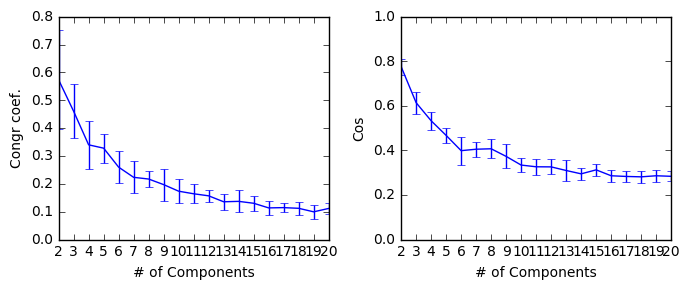

Processing K=2


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Processing K=3


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Processing K=4
Processing K=5
Processing K=6
Processing K=7
Processing K=8
Processing K=9
Processing K=10
Processing K=11
Processing K=12
Processing K=13
Processing K=14
Processing K=15
Processing K=16
Processing K=17
Processing K=18


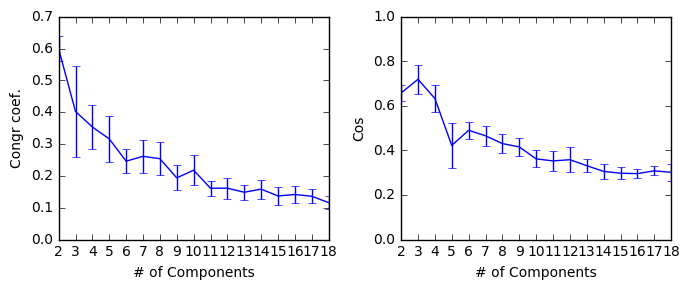

Processing K=2


/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/data1/vbeliveau/software/anaconda3/lib/python3.5/site-packages/sklearn/decomposition/fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


Processing K=3
Processing K=4
Processing K=5
Processing K=6
Processing K=7
Processing K=8
Processing K=9
Processing K=10
Processing K=11
Processing K=12
Processing K=13
Processing K=14


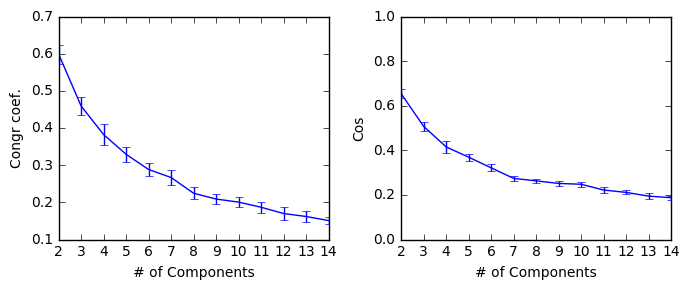

In [81]:
# Evaluate reproducibility of DictLearning on BPnd of individual tracers

tracers=['cumi','dasb','sb','az','C36']
targ='fsaverage5'
sm='10'
hemi_type=['lh']
K_max=20
N_iter=10

print('Loading data')
for tracer,nt in zip(tracers,np.arange(0,len(tracers))):
    
    print('Processing '+tracer)
    
    hemi_data=np.empty(len(hemi_type),dtype=object)
    for hemi,nh in zip(hemi_type,np.arange(0,len(hemi_type))):
        fmask=opj(surf_data,'mask',targ+'.'+hemi)
        fname=opj(BPnd_data,'maps',tracer,'mrtm2.nopvc.' + 
                  targ + '.' + hemi + '.sm' + sm + '.nii.gz')
        hemi_data[nh]=fs.load_surf_data(fname,mask=fmask)
    data_tmp=np.vstack(hemi_data)
    data_tmp=data_tmp.astype('float64')
    data=np.ndarray(data_tmp.shape[1],dtype=object)
    for n in np.arange(0,data_tmp.shape[1]):
        data[n]=data_tmp[:,n]

    K_range=np.arange(2,min(K_max,int(np.floor(len(data)/2)))+1)
    stabil=np.ndarray(len(K_range),dtype=object)
    repro=np.ndarray(len(K_range),dtype=object)
    for K,nk in zip(K_range,np.arange(0,len(K_range))):

        print('Processing K='+str(K))

        def func(data):
            return fs.dict_learning_adapted(np.vstack(data).T,K,alpha=1)

        stabil[nk],repro[nk]=fs.split_half(data,func,n_iter=N_iter,
                                  repro_metric='cos',stabil_metric='congr')

    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1)
    plt.errorbar(K_range,
                 [stabil_k.mean() for stabil_k in stabil],
                 yerr=[stabil_k.std() for stabil_k in stabil])
    plt.xticks(K_range)
    plt.xlabel('# of Components')
    plt.ylabel('Congr coef.')

    plt.subplot(1,2,2)
    plt.errorbar(K_range,
                 [np.nanmean(repro_k,axis=1).mean() for repro_k in repro],
                 yerr=[np.nanmean(repro_k,axis=1).std() for repro_k in repro])
    plt.xticks(K_range)
    plt.axis([K_range[0],K_range[-1],0,1])
    plt.xlabel('# of Components')
    plt.ylabel('Cos')

    plt.tight_layout()
    plt.show()